In [1]:
# imports
import pymc as pm
import pytensor.tensor as pt
import numpy as np
import matplotlib.pyplot as plt
from chronologer.calcurves import download_intcal20
from chronologer.calibration import calibrate, interpolate_calcurve, simulate_c14

In [2]:
def simulate_ippp(rate_func, start, end, max_rate, **kwargs):
    """
    Simulate an inhomogeneous Poisson point process (IPPP).

    Parameters:
    -----------
    rate_func : callable
        The rate function that defines the rate at time t.
    start : float
        Start time of the simulation.
    end : float
        End time of the simulation.
    max_rate : float
        The maximum value of the rate function (for rejection sampling).
    **kwargs : dict
        Additional parameters required by the rate function.

    Returns:
    --------
    np.array
        Array of event times.
    """
    event_times = []
    t = start
    while t < end:
        # Sample inter-event time
        t += np.random.exponential(1 / max_rate)
        if t > end:
            break
        # Accept or reject the event based on the rate function
        if np.random.uniform(0, 1) < rate_func(t, **kwargs) / max_rate:
            event_times.append(t)

    return np.array(event_times)

In [3]:
# Define the rate function for the inhomogeneous Poisson process
def rate_func(t, a, b, d):
    return np.exp(a + b * (t - d))

# Simulation parameters
a_true = -2
b_true = 0.00075
start_time = -10000
end_time = -8000

# Max rate used for rejection sampling
max_rate = rate_func(end_time, a_true, b_true, start_time)

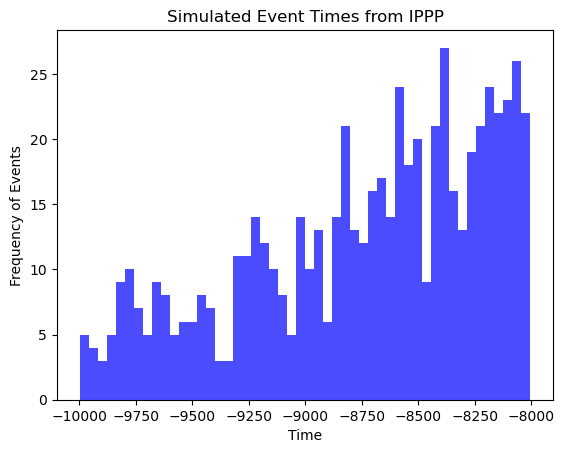

In [5]:
observed_events = simulate_ippp(rate_func, 
                                start=start_time, 
                                end=end_time, 
                                max_rate=max_rate, 
                                a=a_true, 
                                b=b_true,
                                d=start_time)

# Convert observed events into a numpy array for PyMC
observed_events = np.array(observed_events)

# Plot the results
plt.hist(observed_events, bins=50, alpha=0.7, color='blue')
plt.title('Simulated Event Times from IPPP')
plt.xlabel('Time')
plt.ylabel('Frequency of Events')
plt.show()

In [12]:
def approx_integral(rate_func, domain):
    """
    Approximates the integral of the rate function over a given domain.

    Parameters:
    -----------
    rate_func : callable
        The rate function to be integrated, should take a tensor as input.
    domain : tensor
        A sequence of points over which the rate function is evaluated.

    Returns:
    --------
    TensorVariable
        The approximate integral of the rate function over the domain.
    """
    # Evaluate the rate function at the points in the domain
    rate_values = rate_func(domain)

    # Number of evaluation points (inferred from the domain shape)
    eval_n = domain.shape[0]
    
    # Approximate the integral using the sum of the rate values times the step size
    # Assume equally spaced points in domain unless provided differently
    integral_rate = pt.sum(rate_values) * (domain[-1] - domain[0]) / eval_n
    
    return integral_rate

def ippp_logp_lm(value, a, b, d, domain):
    """
    Log-likelihood function for IPPP using a linear function with tensor-compatible parameters.

    Parameters:
    -----------
    tau : tensor
        Observed event times as a PyTensor tensor.
    a : float
        Amplitude of the sine wave.
    b : float
        Period of the sine wave.
    d : float
        Start of time interval for process.
    domain : tensor
        The sequence of regularly-spaced points over which the GP or other 
        covariate function is evaluated (for integral approximation).

    Returns:
    --------
    TensorVariable
        Log-likelihood of observing the event times based on the IPPP model.
    """
    # Define the rate function using a and b
    rate_func = lambda t: pt.exp(a + b * (t - d))

    # Log-likelihood: sum of log(rate) at event times
    log_rate_sum = pt.sum(pt.log(rate_func(value)))

    # Approximate the integral over the interval [start, end]
    integral_rate = approx_integral(rate_func, domain)

    # Return the log-likelihood
    return log_rate_sum - integral_rate

In [16]:
eval_n = 1000 # controls the resolution of the integration
domain = pt.linspace(start_time, end_time, eval_n)

with pm.Model() as model:
    # Define priors for the rate function parameters
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=0.0005)

    # Step 3: Add the IPPP log-likelihood, conditioned on N events
    ippp = pm.Potential('ippp_likelihood', ippp_logp_lm(observed_events, a, b, start_time, domain))

    # Sampling from the posterior
    step = pm.Metropolis()
    trace = pm.sample(draws=2000, tune=2000, step=step, chains = 1)


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [a]
>Metropolis: [b]


Output()

Sampling 1 chain for 2_000 tune and 2_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [17]:
pm.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-2.011,0.097,-2.165,-1.821,0.021,0.015,24.0,38.0,NaN
b,0.001,0.000,0.001,0.001,0.000,0.000,19.0,19.0,NaN


array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>],
      dtype=object)

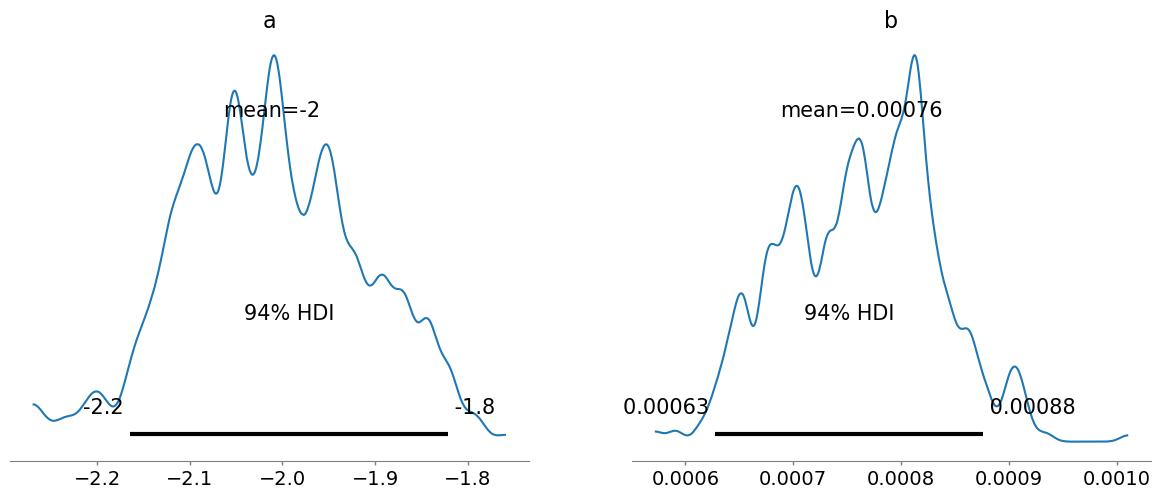

In [18]:
pm.plot_posterior(trace)

In [19]:
N = observed_events.shape[0]
error_sd = np.repeat(30, N)  # Assume constant lab error

measured_events = np.random.normal(loc=observed_events, scale=30)

# Setting up the domain for the integration
start = -10000
end = -8000
eval_n = 1000  # controls the resolution of the integration
domain = pt.linspace(-10000, -8000, eval_n)

with pm.Model() as model:
    # Define priors for the rate function parameters
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Normal('b', mu=0, sigma=0.0005)

    # Step 1: Latent event times `tau` (unknown true event times)
    # These are the true latent event times, which we want to infer.
    # We do not directly observe them but have noisy measurements of them.
    tau = pm.Uniform('tau', lower=start, upper=end, shape=N)

    # Step 2: Define an error model between the latent event times `tau` and the observed event times
    observed_times = pm.Normal('observed_times', mu=tau, sigma=error_sd, observed=measured_events)

    # Step 3: Add the IPPP log-likelihood, conditioned on N events
    ippp = pm.Potential('ippp_likelihood', ippp_logp_lm(tau, a, b, start_time, domain))

    # Sampling from the posterior
    step = pm.Metropolis()
    trace = pm.sample(draws=2000, tune=2000, step=step, chains = 1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [a]
>Metropolis: [b]
>Metropolis: [tau]


Output()

Sampling 1 chain for 2_000 tune and 2_000 draw iterations (2_000 + 2_000 draws total) took 614 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [20]:
pm.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-2.031,0.093,-2.187,-1.856,0.014,0.010,45.0,111.0,NaN
b,0.001,0.000,0.001,0.001,0.000,0.000,48.0,101.0,NaN
tau[0],-9954.743,25.100,-9996.559,-9912.249,1.187,0.840,433.0,479.0,NaN
tau[1],-9962.127,24.015,-9999.875,-9921.364,1.249,0.884,314.0,274.0,NaN
tau[2],-9978.957,16.019,-9999.660,-9950.096,0.780,0.552,371.0,389.0,NaN
...,...,...,...,...,...,...,...,...,...
tau[624],-8027.032,20.018,-8064.843,-8000.002,1.161,0.822,198.0,116.0,NaN
tau[625],-8021.372,17.780,-8053.736,-8000.051,0.952,0.674,256.0,257.0,NaN
tau[626],-8022.524,17.162,-8054.249,-8000.017,0.876,0.620,373.0,566.0,NaN
tau[627],-8029.689,21.375,-8067.379,-8000.007,1.153,0.816,260.0,217.0,NaN


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

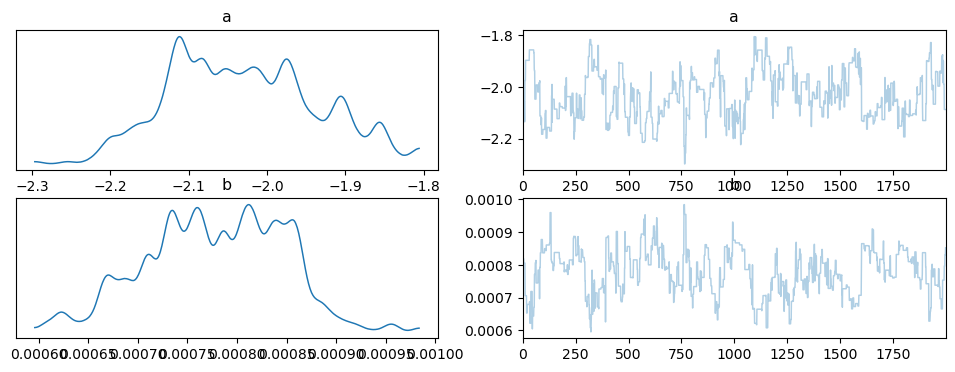

In [21]:
pm.plot_trace(trace, var_names=["a", "b"])

array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>],
      dtype=object)

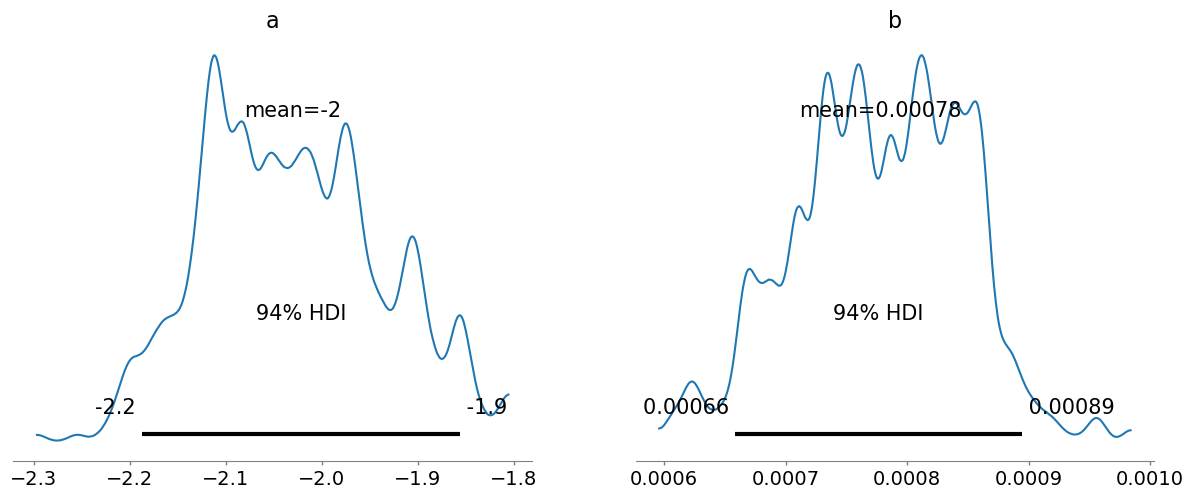

In [22]:
# plot the posterior densities for the top-level, process model parameters
pm.plot_posterior(trace, var_names=["a", "b"])

In [31]:
# setup
# Example usage to create initial intcal20 dictionary
intcal20 = download_intcal20()

# recast calibration curve data as tensors for use in PyMC model context
calbp_tensor = pt.as_tensor_variable(intcal20['calbp'])
c14bp_tensor = pt.as_tensor_variable(intcal20['c14bp'])
c14_sigma_tensor = pt.as_tensor_variable(intcal20['c14_sigma'])

# intensity function
# Define the rate function for the inhomogeneous Poisson process
def rate_func(t, a, b, d):
    return np.exp(a + b * (t - d))

# simulation params
a_true = -3
b_true = 0.00075
start = -10000
end = -8000
eval_n = 1000  # controls the resolution of the integration
domain = pt.linspace(-10000, -8000, eval_n)
max_rate = rate_func(end, a_true, b_true, start)
# simulate more calendar ages from the sine function
calendar_ages = simulate_ippp(rate_func, 
                                start=start, 
                                end=end, 
                                max_rate=max_rate, 
                                a=a_true, 
                                b=b_true,
                                d=start)

# Convert observed events into a numpy array for PyMC
calendar_ages = np.array(calendar_ages)

# Simulate radiocarbon dates based on the true calendar dates (use your simulate_c14 function here)
radiocarbon_age = simulate_c14(calendar_ages, 
                               intcal20['calbp'], 
                               intcal20['c14bp'], 
                               intcal20['c14_sigma'])

N = calendar_ages.shape[0]

radiocarbon_error = np.repeat(30, N)  # Assume constant lab error

c:\users\carleton\documents\projects\chronologer\chronologer\chronologer\calcurves.py:19: UserWarning: Calibration curve data is not strictly increasing. Adjusting sign to correct...
  warnings.warn("Calibration curve data is not strictly increasing. Adjusting sign to correct...")


In [32]:
# Precompute calibration limits
cal_dates = calibrate(radiocarbon_ages = radiocarbon_age, 
                        radiocarbon_errors = radiocarbon_error, 
                        calbp = intcal20['calbp'], 
                        c14bp = intcal20['c14bp'], 
                        c14_sigma = intcal20['c14_sigma'], 
                        hdi_prob = 0.999999)

lower_bound = cal_dates['HDI Lower (BP)'].values
upper_bound = cal_dates['HDI Upper (BP)'].values

cal_dates

,Radiocarbon Age,Mean Calibrated Age (BP),Std Dev (BP),HDI Lower (BP),HDI Upper (BP)
0,-8898.400707,-10034.249767,83.504960,-10230,-9670
1,-8905.091371,-10038.950859,83.011137,-10230,-9680
2,-8829.337437,-9909.314364,122.254361,-10195,-9555
3,-8920.911655,-10050.767542,84.348552,-10235,-9690
4,-8858.663036,-9988.747141,106.689564,-10215,-9560
...,...,...,...,...,...
219,-7248.118005,-8076.867849,56.766607,-8285,-7875
220,-7271.506865,-8096.179577,48.290083,-8310,-7935
221,-7196.895196,-7999.189518,34.679578,-8180,-7845
222,-7174.246068,-7984.392469,26.993579,-8175,-7800


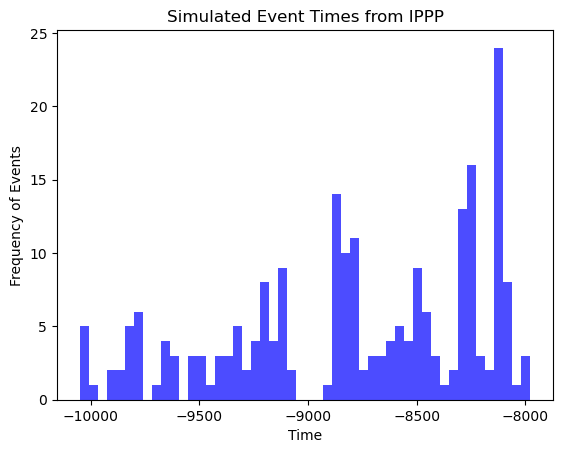

In [33]:
# Plot the results
plt.hist(cal_dates['Mean Calibrated Age (BP)'], bins=50, alpha=0.7, color='blue')
plt.title('Simulated Event Times from IPPP')
plt.xlabel('Time')
plt.ylabel('Frequency of Events')
plt.show()

In [25]:
cal_upper_bound = max(upper_bound) * (1 - 0.3)
cal_lower_bound = min(lower_bound) * (1 + 0.3)
print( (cal_lower_bound,cal_upper_bound) )

(-13305.5, -5558.0)


In [26]:
with pm.Model() as model:
    # Define priors for the rate function parameters
    # Scaling parameters
    a_mean, a_scale = 0, 1
    b_mean, b_scale = 0, 0.0005

    # Scaled priors
    a_scaled = pm.Normal('a_scaled', mu=0, sigma=1)
    b_scaled = pm.Normal('b_scaled', mu=0, sigma=1)

    # Reparameterize a and b
    a = pm.Deterministic('a', a_mean + a_scale * a_scaled)
    b = pm.Deterministic('b', b_mean + b_scale * b_scaled)

    # Step 1: Latent event times `tau` (unknown true event times)
    # These are the true latent event times, which we want to infer.
    # We do not directly observe them but have noisy measurements of them.
    tau = pm.Uniform('tau', lower=start, upper=end, shape=N)

    # Step 2: Define an error model between the latent event times `tau` and the observed event times
    # calibration model
    mean, error = interpolate_calcurve(tau, calbp_tensor, c14bp_tensor, c14_sigma_tensor)

    r_latent = pm.Normal('r_latent', mu=mean, sigma=error, shape=N)
    
    r_measured = pm.Normal('r_measured', mu=r_latent, sigma=radiocarbon_error, observed=radiocarbon_age)

    # Step 3: Add the IPPP log-likelihood, conditioned on N events
    ippp = pm.Potential('ippp_likelihood', ippp_logp_lm(tau, a, b, start, domain))

    # Sampling from the posterior
    step = pm.Metropolis()
    trace = pm.sample(draws=2000, tune=2000, step=step, chains = 1)
    # Assign samplers for specific parameters
    #step = [
    #    pm.Slice([a_scaled, b_scaled]),        # Slice sampler for a and b
    #    pm.Metropolis([tau])     # Metropolis for latent tau variables
    #]
    #trace = pm.sample(draws=2000, tune=2000, step=step, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [a_scaled]
>Metropolis: [b_scaled]
>Metropolis: [tau]
>Metropolis: [r_latent]


Output()

Sampling 1 chain for 2_000 tune and 2_000 draw iterations (2_000 + 2_000 draws total) took 4734 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [27]:
pm.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-2.611,0.157,-2.914,-2.337,0.024,0.018,47.0,139.0,NaN
a_scaled,-2.611,0.157,-2.914,-2.337,0.024,0.018,47.0,139.0,NaN
b,-0.000,0.000,-0.000,0.000,0.000,0.000,23.0,100.0,NaN
b_scaled,-0.260,0.279,-0.701,0.285,0.056,0.040,23.0,100.0,NaN
r_latent[0],-8893.363,21.939,-8932.620,-8851.468,1.777,1.259,153.0,276.0,NaN
...,...,...,...,...,...,...,...,...,...
tau[122],-8103.838,46.163,-8178.139,-8031.188,3.230,2.288,161.0,159.0,NaN
tau[123],-8097.339,45.880,-8165.716,-8018.181,3.079,2.180,198.0,188.0,NaN
tau[124],-8104.452,46.582,-8173.085,-8026.317,3.432,2.434,163.0,37.0,NaN
tau[125],-8124.423,63.449,-8202.764,-8029.291,10.474,7.477,33.0,61.0,NaN


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

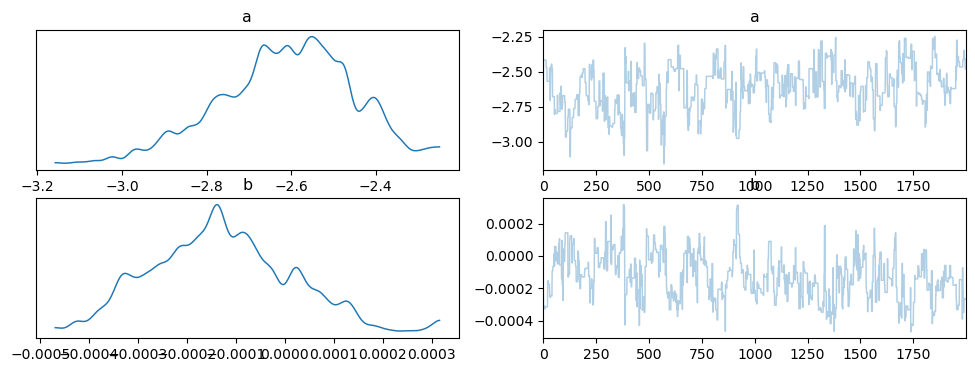

In [28]:
pm.plot_trace(trace, var_names=["a", "b"])

array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>],
      dtype=object)

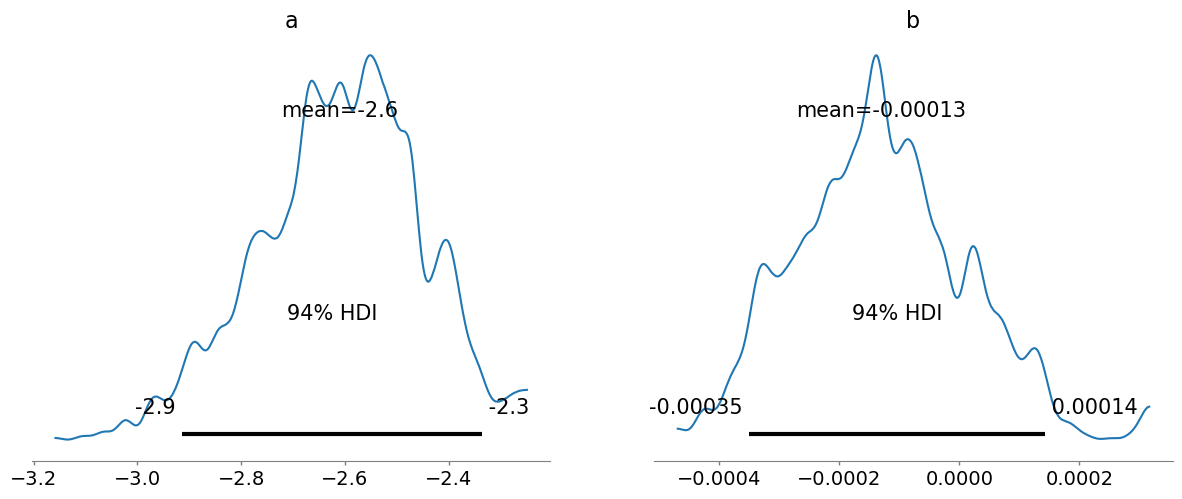

In [29]:
pm.plot_posterior(trace, var_names=["a", "b"])